 ### Overview
 A restaurant group wanted to gauge people's opinions towards to sit-down-dining during the COVID crisis
 and track any changes over time.
 Decided to measure this with a survey asking people how often they dine in a sitdown restaurant and how often they expected to
 in the coming year.
 In June 2020 ran the initial survey. Followed up with a new survey in
 October 2020
 ### Findings
 <ul>
 <li>The October survey found that diners are choosing to eat out more often.</li>
 <li>The number of respondents that said they eat out less than once per month declined
 by approximately 7%.</li>
 <li>Wave 1 70% of people reported eating out less than once per month.</li>
 <li>Wave 2 this decreased to 65%</li>
 </ul>

 ### Methods
 <ul><li>Survey respondents were recruited from Amazon's Mechanical Turk where they were sent to a
 simple online survey hosted with Google Forms.</li>
 <li>Respondents were weighted to match the internet
 population. </li>
 </ul>

 ### Weighting Variables
 <ul>
 <li>Age</li>
 <li>Gender</li>
 <li>Education</li>
 </ul>
 ### Contents
<ul>
 <li>Creating surveys weight with IPF</li>
 <li>Comparings waves</li>
 <li>Cluster analysis</li>
 <li>Predictors of eating out</li>
</ul>
 _* This is very much a work in progress_

In [1]:
import pandas as pd
import numpy as np
from ipfn.ipfn import ipfn
import pytest
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

In [2]:
def survey_cleanup_weighting(path, file):
    df = pd.read_csv(path+file)
    # dropping duplicate survey takers and columns don't need
    df.drop_duplicates('What is your Amazon Worker ID?', inplace=True)
    #df.drop(['What is your Amazon Worker ID?', 'Unnamed: 9', 'Timestamp', 'In what zip code do you live?'], axis=1, inplace=True)
    # making human readable names
    df.rename(
        {
            'Before the coronavirus crisis, how often did you eat out at a sit-down restaurant?':'precovid',
            'Currently how often do you eat out at a sit-down restaurant?': 'current',
            "Next year how often do you think you'll eat out at a sit-down restaurant?": 'postcovid',
            'What is your gender?': 'gender',
            'What is the highest level of education you have completed?': 'educ'
        },
        axis = 1,
        inplace = True
    )
    df['age_years'] = (2020-df['In what year were you born?'])
    #creating category for min number of times currently eat out per category per month
    df['current_freq'] = df.current
    df['current_freq'] = df.current_freq.map({'Less than once per month' : 0, 'Once a month': 1, 'Multiple time per month' : 3, 'Once a week': 4, 'Multiple times per week': 8 })
    # get age, bin, and drop year column
    df['age'] = pd.cut(2020 - df['In what year were you born?'], bins=[-1, 24, 34, 44, 54, 64, 1000],
        labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+'])
    df.drop(['In what year were you born?'], axis=1, inplace=True)
    # too few responses to estimate
    df = df.loc[df.gender != 'Other', :]
    # grouping educ into college, not college
    df['educ'] = df.educ.map({'College graduate': 'college', 'Post-graduate (e.g. MS, MBA, PhD, etc.)': 'college',
                        'High school' : 'not_college', 'Did not finish high school': 'not_college'})
    # fixing indexing after dropping some rows
    df.reset_index(drop=True, inplace=True)
    # Weighting
    np.random.seed(1)

    bias_vars = ['gender', 'educ', 'age']
    samp_aggs = [df[col].value_counts().sort_index().values for col in bias_vars]   # marginal counts
    dims = [[i] for i in range(len(samp_aggs))]  # i'm using 1-d marginals
    # print(aggs, dims)

    # random initial values, using poisson to get count-like values
    samp_init = np.random.poisson(np.mean([np.mean(x) for x in samp_aggs]), (2,2,6)) + 1  

    ipf = ipfn(samp_init, samp_aggs, dims)
    samp_dist = ipf.iteration()
    samp_dist = samp_dist / np.sum(samp_dist)  # normalizing it to a proper distribution
    
    # repeating for population marginals
    np.random.seed(1)
    from collections import OrderedDict
    # ['gender', 'educ', 'age']
    refdist = OrderedDict({
        'gender': {'Female': .52, 'Male': .48},  
        'educ':  {'college': .35, 'not_college': .65}, 
        # i added .001 to '65+' to make it exactly sum to 1
        'age': {'18-24': .141, '25-34': .194, '35-44': .187, '45-54': .194, '55-64': .160, '65+': .124}
    })
    ## checking that everything looks ok
    for i, k in enumerate(refdist.keys()):
        assert bias_vars[i] == k  # names in right order?
    for k,v in refdist.items():
        assert set(v.keys()) == set(df[k])  # unique values all correct?
        assert sum(v.values()) == 1.  # each a proper distribution?
    ref_aggs = [pd.Series(v).sort_index().values for v in refdist.values()]
    # random initial values, using unif(.25,.75) to get probability-like values
    ref_init = np.random.uniform(.25,.75, (2,2,6)) 
    ipf = ipfn(ref_init, ref_aggs, dims)  # reusing same dims
    pop_dist = ipf.iteration()
    # creating table for weights
    wt_arr = pop_dist / samp_dist
    

    dimnames = [df[col].value_counts().sort_index().index for col in bias_vars] 
    wt_df = pd.DataFrame(np.zeros((np.prod(wt_arr.shape), len(refdist) + 1))) # +1 for wt column
    wt_df.columns = list(refdist.keys()) + ['wt']

    l = 0
    for i, f in enumerate(refdist['gender'].keys()):
        for j, e in enumerate(refdist['educ'].keys()):
            for k, a in enumerate(refdist['age'].keys()):
                wt_df.iloc[l,:len(refdist)] = [f,e,a]
                wt_df.iloc[l,len(refdist)] = wt_arr[i,j,k]
                l += 1
    #Adding the weights back to the data frame
    df = pd.merge(df, wt_df, on =['gender','educ','age'])
    df['wt'] = df.wt / df.wt.mean()
    # new quesitons added for wave2
    df.rename({'Currently, about how often do you order takeout?':'how_often_takeout'}, axis = 1, inplace = True)
    df.rename({'What is your annual household income?':'household_income'}, axis= 1, inplace= True)
    print(df.head(3))
    return df


In [3]:
path = 'C:/Users/matth/environments/dsci1_env/restaurants_covid/'
file = 'Dining Out Survey (Responses) - Form Responses 1.csv'

df_wv1 = survey_cleanup_weighting(path, file)
df_wv2 = survey_cleanup_weighting(path, 'Dining Out Survey Batch 3 (Responses) - Form Responses 1.csv')

            Timestamp                 precovid                   current  \
0  6/17/2020 22:09:53              Once a week   Multiple time per month   
1  6/17/2020 22:12:27  Multiple time per month  Less than once per month   
2  6/17/2020 22:12:55  Multiple time per month  Less than once per month   

                 postcovid  In what zip code do you live? gender         educ  \
0  Multiple time per month                        77338.0   Male  not_college   
1             Once a month                        10128.0   Male  not_college   
2             Once a month                        24018.0   Male  not_college   

  What is your Amazon Worker ID?  Unnamed: 9  age_years  current_freq    age  \
0                 A1PLYU7HZ97RF0         NaN         23             3  18-24   
1                 A2WF1ZVAMMT5M7         NaN         20             0  18-24   
2                 A2GA1PMGA9TSZM         NaN         20             0  18-24   

         wt  
0  3.171091  
1  3.171091  
2  3.17

In [4]:
df_wv2.head()

,Timestamp,precovid,current,postcovid,how_often_takeout,In what zip code do you live?,gender,educ,household_income,What is your Amazon Worker ID?,age_years,current_freq,age,wt
0,10/17/2020 15:57:34,Multiple time per month,Less than once per month,Less than once per month,Once a month,11233,Male,college,150000,AE5KSMPSSM4XK,36,0,35-44,0.185518
1,10/17/2020 15:58:36,Multiple times per week,Multiple times per week,Multiple times per week,Multiple time per month,74012,Male,college,75000,A2JC65REBH7706,41,8,35-44,0.185518
2,10/17/2020 15:58:51,Once a week,Less than once per month,Less than once per month,Once a week,48085,Male,college,55000,A2CSV75E3JT58Y,36,0,35-44,0.185518
3,10/17/2020 15:58:58,Multiple times per week,Multiple time per month,Multiple times per week,Once a week,11542,Male,college,185000,AKSLU0C30G3JT,40,3,35-44,0.185518
4,10/17/2020 16:00:01,Multiple times per week,Once a week,Multiple times per week,Multiple times per week,76040,Male,college,2500,A13YTGRLTS80MU,35,4,35-44,0.185518


 # Comparing Waves

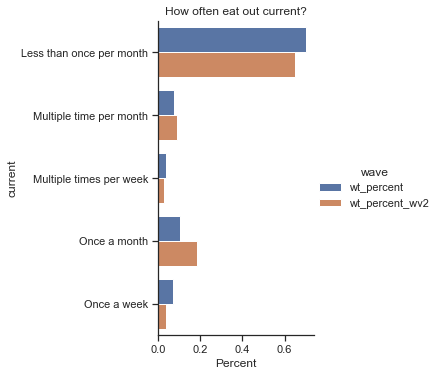

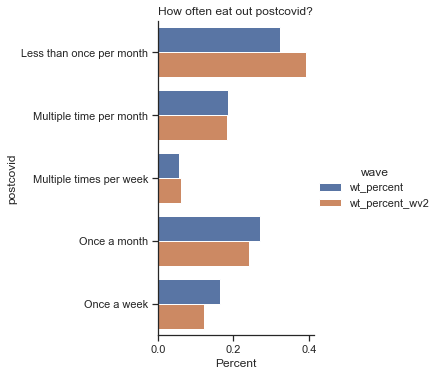

In [5]:
def compare_waves(question, wave_a, wave_b):
    def chart_df(question, wave):
        q_wv1 = wave.groupby(wave[question], dropna=False)['wt'].sum().reset_index()
        q_wv1['wt_percent'] = q_wv1['wt']/q_wv1['wt'].sum()
        return q_wv1
    q_wv1 = chart_df(question, wave_a)
    q_wv2 = chart_df(question, wave_b)
    df = q_wv1[[question, 'wt_percent']].copy()
    df['wt_percent_wv2'] = q_wv2['wt_percent']
    df = pd.melt(df, id_vars=question, var_name='wave' , value_name='percent') #making wave a var
    sns.catplot(x = 'percent', y = question, hue='wave', data=df, kind='bar' )
    plt.xlabel('Percent')
    plt.title('How often eat out ' + question + '?')
compare_waves('current', df_wv1, df_wv2)    
compare_waves('postcovid', df_wv1, df_wv2) 

 ## Cluster Analysis

In [6]:
df2 = df_wv1[['age_years', 'current_freq']].copy()
df2.current_freq = df2.current_freq / df2.current_freq.max()
df2.age_years= df2.age_years / df2.age_years.max()

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
#df2 = df_wv1[['age_years', 'current_freq']].copy()
#df2 = df_wv1[['current_freq']].copy()

x = np.array(df2)
#kmeans.fit(x)
kmeans.fit(df2)
df2['cluster'] = kmeans.labels_
df2['age_years2'] = df_wv1['age_years']
df2['current_freq2'] = df_wv1.current_freq

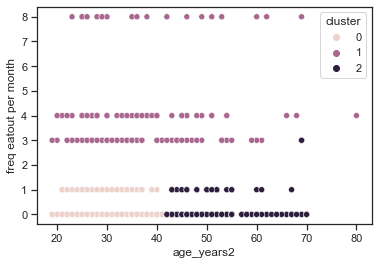

In [7]:
fig = sns.scatterplot(data=df2, x='age_years2', y='current_freq2', hue='cluster')
plt.ylabel("freq eatout per month")
plt.show(fig)

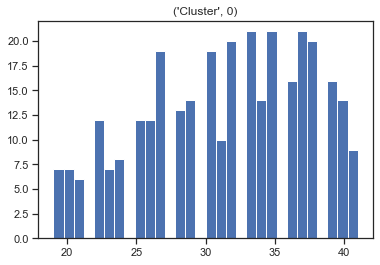

median age 32.0


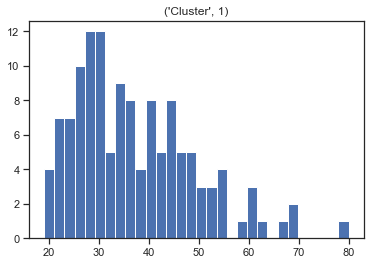

median age 35.0


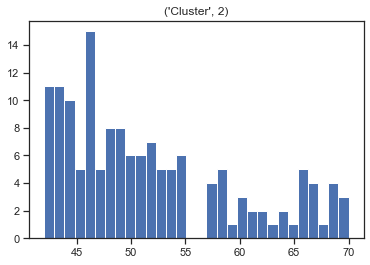

median age 49.5


In [8]:
def cluster_age_chart(clus):
    x_plot = df2.loc[(df2['cluster'] == clus)]
    plt.hist(x_plot.age_years2, bins=30)
    title = ('Cluster', clus)
    plt.title(title)
    plt.show()
    print('median age', x_plot.age_years2.median())
cluster_age_chart(0)
cluster_age_chart(1)
cluster_age_chart(2)


 ## Predictors of eating out